<a href="https://colab.research.google.com/github/Shelly10-10/CODSOFT/blob/main/flood_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv("improved_flood_dataset.csv")
#feature selection
features = [
    'Latitude', 'Longitude',
    'Rainfall_mm', 'River_Level_m', 'Tide_Level_m', 'Soil_Saturation_%',
    'Land_Elevation_m', 'Distance_to_Coast_km',
    'Temperature_C', 'Humidity_%', 'Wind_Speed_kmph',
    'Evaporation_mm', 'Satellite_Cloud_Index',
    'Cyclone_Alert',
    'Infrastructure_Grade',
]

X = df[features]
y = df['Flood_Reported']


In [4]:
X['Infrastructure_Grade'] = X['Infrastructure_Grade'].map({
    'A': 4, 'B': 3, 'C': 2, 'D': 1
})


In [5]:
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)


In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}


In [10]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    f1 = report['weighted avg']['f1-score']

    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    results.append((name, acc, f1, roc_auc))


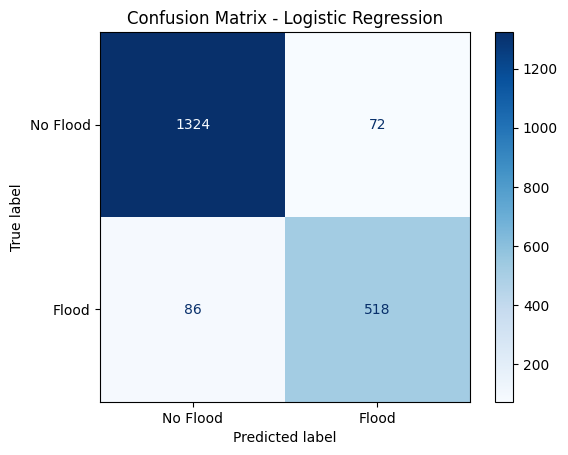

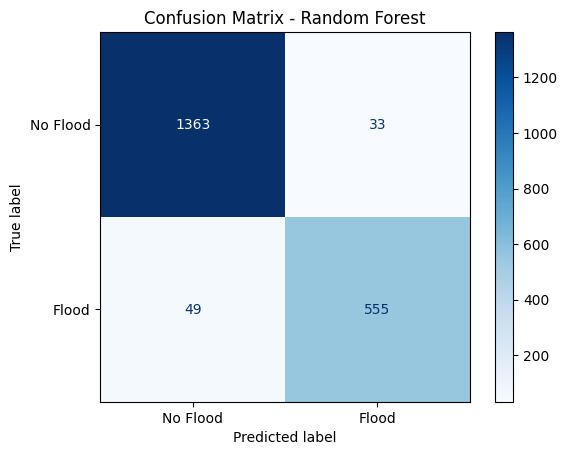

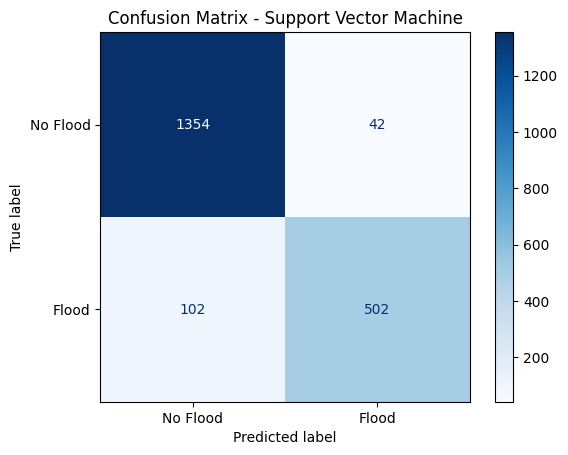

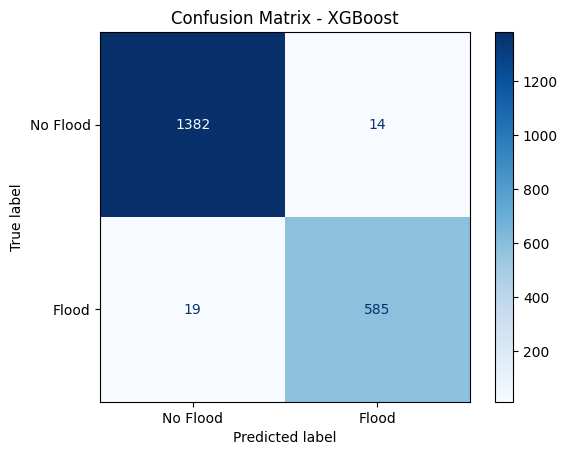

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["No Flood", "Flood"]
    )

    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


In [15]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'F1', 'AUC'])
best_ml_model_name = results_df.sort_values(by='F1', ascending=False).iloc[0]['Model']
best_ml_model = models[best_ml_model_name]


In [17]:
explainer = shap.Explainer(best_ml_model, X_test)

In [18]:
shap_values = explainer(X_test, check_additivity=False)


100%|===================| 1991/2000 [00:15<00:00]       

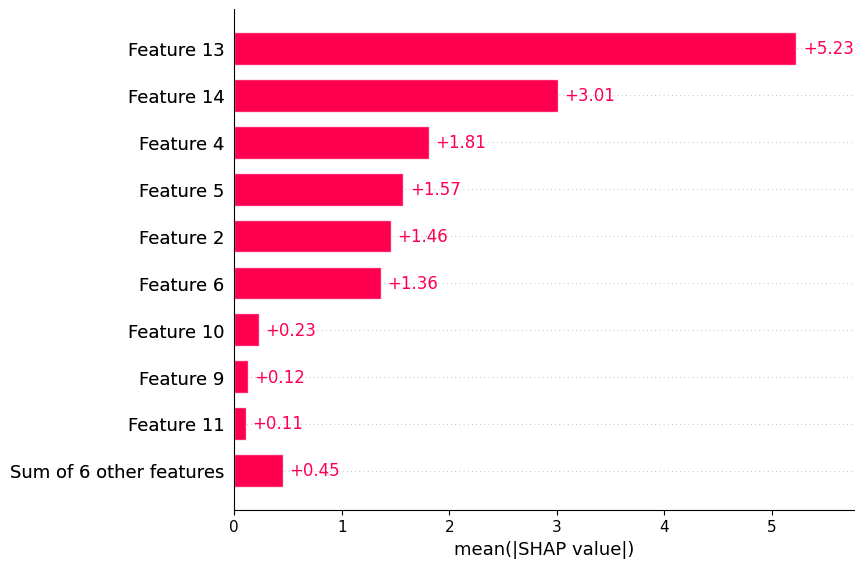

In [19]:
shap.plots.bar(shap_values, max_display=10)


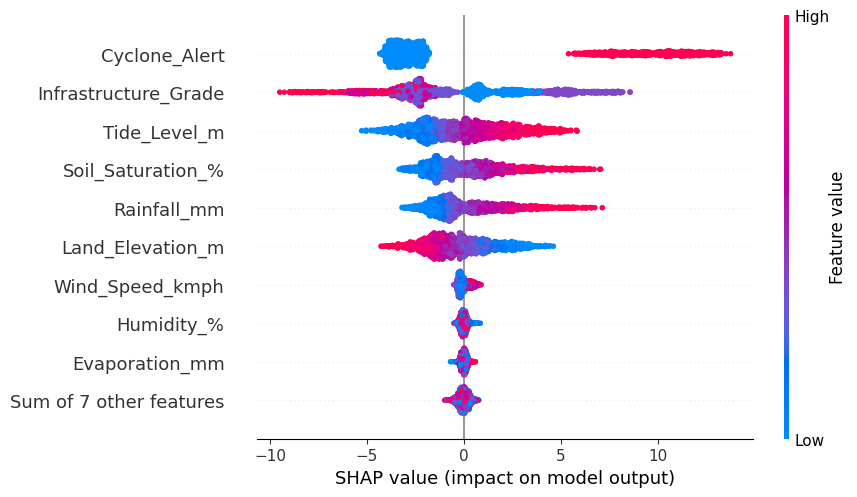

In [50]:
shap.plots.beeswarm(shap_values)



In [20]:
#FNN ARCHITECTURE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

fnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

fnn_model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [21]:
#TRAIN FNN
history = fnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7583 - loss: 0.4969 - val_accuracy: 0.9144 - val_loss: 0.2446
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8913 - loss: 0.2751 - val_accuracy: 0.9144 - val_loss: 0.2152
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8938 - loss: 0.2478 - val_accuracy: 0.9162 - val_loss: 0.1991
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9069 - loss: 0.2198 - val_accuracy: 0.9262 - val_loss: 0.1887
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9115 - loss: 0.2124 - val_accuracy: 0.9231 - val_loss: 0.1793
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9102 - loss: 0.2017 - val_accuracy: 0.9287 - val_loss: 0.1710
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9161 - loss: 0.1864 - val_accuracy: 0.9287 - val_loss: 0.1656
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9141 - loss: 0.1857 - val_accuracy: 0.

In [22]:
y_pred_fnn = (fnn_model.predict(X_test) > 0.5).astype(int)
fnn_acc = accuracy_score(y_test, y_pred_fnn)
print("FNN Accuracy:", fnn_acc)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
FNN Accuracy: 0.9905


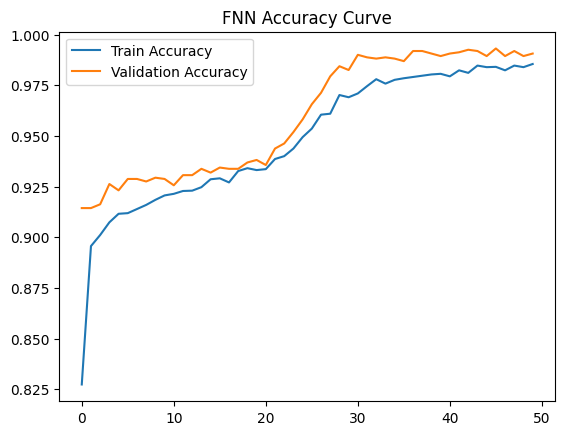

In [23]:
#PLOT LEARNING CURVE
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("FNN Accuracy Curve")
plt.show()


In [68]:
import shap

# Convert background to DataFrame (optional but better for feature names)
X_bg_df = pd.DataFrame(X_bg, columns=features)
X_sample_df = pd.DataFrame(X_test[:50], columns=features)

# Use DeepExplainer with Keras model
explainer_fnn = shap.DeepExplainer(fnn_model, X_bg_df)

# Compute SHAP values
shap_values_fnn = explainer_fnn.shap_values(X_sample_df)

# Plot summary
shap.summary_plot(shap_values_fnn[0], X_sample_df)


KeyError: 0

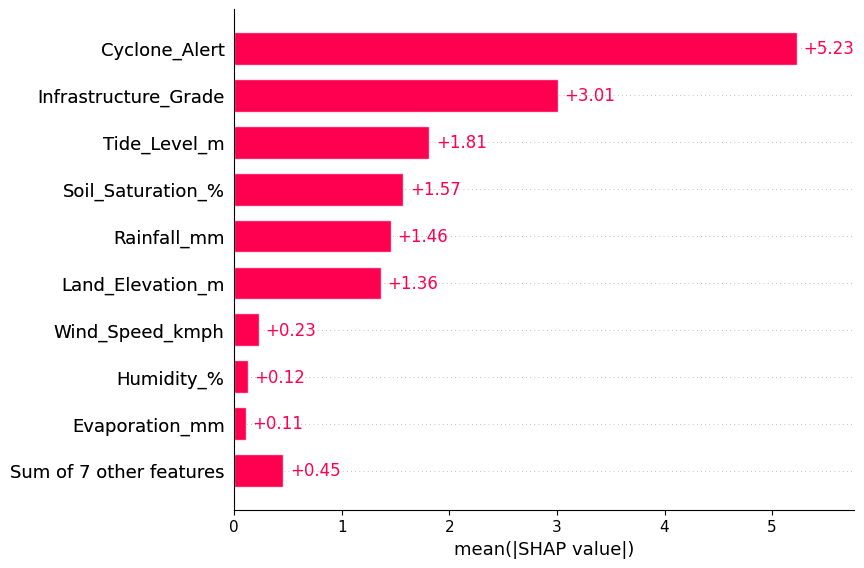

In [56]:
shap.plots.bar(shap_values, max_display=10)


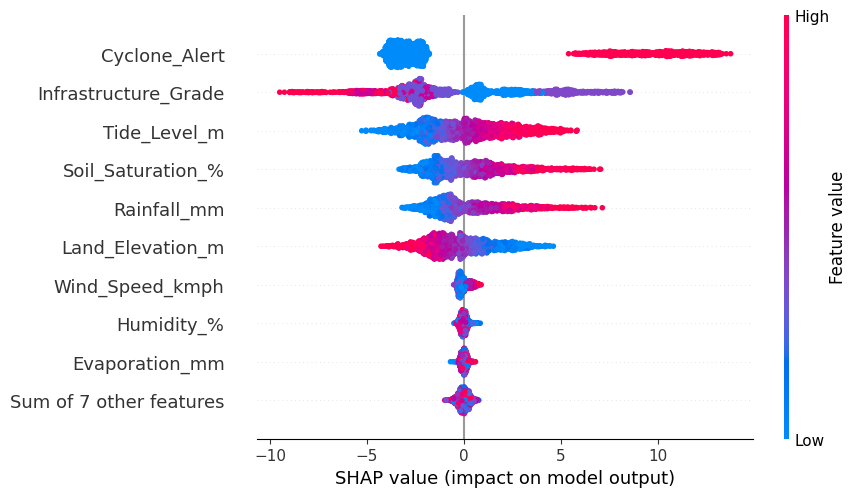

In [57]:
shap.plots.beeswarm(shap_values)


In [60]:
import shap
import numpy as np

# -------------------------------
# 1. Background dataset for SHAP
# -------------------------------
# Take a random sample of 100 rows from training data
X_bg = X_train.sample(n=100, random_state=42)

# -------------------------------
# 2. Sample dataset to explain
# -------------------------------
# Take first 50 rows from test data
X_sample = X_test.iloc[:50]

# -------------------------------
# 3. Feature names
# -------------------------------
features = X_train.columns.tolist()  # ensures all columns are included

# -------------------------------
# 4. Create KernelExplainer
# -------------------------------
explainer_fnn = shap.KernelExplainer(fnn_model.predict, X_bg)

# -------------------------------
# 5. Compute SHAP values
# -------------------------------
shap_values_fnn = explainer_fnn.shap_values(X_sample)

# -------------------------------
# 6. Plot SHAP summary
# -------------------------------
shap.summary_plot(shap_values_fnn, X_sample, feature_names=features)


AttributeError: 'numpy.ndarray' object has no attribute 'sample'

In [66]:
import shap
X_bg_df = pd.DataFrame(X_bg, columns=features)
X_sample_df = pd.DataFrame(X_sample, columns=features)

explainer_fnn = shap.DeepExplainer(fnn_model, X_bg_df)
shap_values_fnn = explainer_fnn.shap_values(X_sample_df)
shap.summary_plot(shap_values_fnn, X_sample_df)


KeyError: 0